This jupyter notebook is a report of my key discoveries and conclusions. To successfully run all the codes, please add the [sp500.h5](https://drive.google.com/file/d/1uPPN3GYKG_DnkeQbQRYMyFvgLmrcvBFZ/view?usp=sharing) file to such a path: /content/drive/MyDrive/sp500.h5

## Part 0. Load data

First, we install the package *tables* for reading *hdf* files.

In [1]:
!pip install tables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then, we import the packages that are useful throughout the project.

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import copy
import os

We read the *hdf* file and print it out.

In [3]:
drive.mount('/content/drive')
ori_data = pd.read_hdf('/content/drive/MyDrive/sp500.h5')
ori_data

Mounted at /content/drive


price_adj  price_close  price_open  price_high   price_low  \
date       uspn                                                                
2000-01-04 A      40.910591    47.567955   48.730328   49.266811   46.316166   
           AAPL    3.177650     3.660714    3.866071    3.950893    3.613839   
           ABC     2.791193     3.625000    3.687500    3.703125    3.500000   
           ABMD   17.812500    17.812500   18.500000   18.500000   17.000000   
           ABT     6.377004    15.262630   15.459024   15.599305   15.150405   
...                     ...          ...         ...         ...         ...   
2019-12-31 XYL    78.547081    78.790001   78.870003   79.120003   78.239998   
           YUM   100.280571   100.730003  100.669998  101.169998  100.230003   
           ZBH   149.308990   149.679993  148.289993  149.710007  148.289993   
           ZION   51.538563    51.919998   51.610001   52.040001   51.610001   
           ZTS   131.945450   132.350006  132.009995  132.580002  131.449997   

                      volume  sp_weight   ret_raw  
date       uspn                                    
2000-01-04 A       4765000.0   0.096007 -0.076389  
           AAPL  128094400.0   3.851850 -0.084310  
           ABC      944000.0   0.051664 -0.068273  
           ABMD      34400.0   0.032319 -0.023973  
           ABT    10734600.0   0.598686 -0.028572  
...                      ...        ...       ...  
2019-12-31 XYL      492000.0   0.057616  0.000635  
           YUM     1271000.0   0.139869  0.000894  
           ZBH      612400.0   0.112949  0.006252  
           ZION    1246900.0   0.032859  0.002897  
           ZTS     1128600.0   0.240081  0.001059  

[2250490 rows x 8 columns]

## Part 1. Naive Method: Exponential Weighted Moving Average

We define a *EWMA* (Exponential Weighted Moving Average) class to predict the volume of the *t*th day for each stock, based on the exponentially-decaying weighted average of the first *t-1* days' volumes.   

In [4]:
# Exponential Weighted Moving Average
class EWMA:
  def __init__(self, halftime=60):
    self.halftime = halftime
  
  def predict(self, ori_data):
    # input: data, (num_dates, num_stocks)
    # output: pred, (num_dates, num_stocks)

    data = ori_data['volume'].unstack().sort_index(axis=1).to_numpy() # (num_stocks, num_dates)
    num_dates, num_stocks = data.shape
    
    # weights: [num_dates, num_dates] triangle matrix
    weights = np.zeros((num_dates, num_dates))
    for day in range(num_dates):
      weight = np.logspace(day, 0, day+1, base=0.5**(1./self.halftime))
      weight = weight / np.sum(weight)
      weights[day, :(day+1)] = weight

    # move all nan to the bottom and replace them by zeros
    rows, columns = np.ogrid[:num_dates, :num_stocks]
    index_nan = np.isnan(data)
    nan_count = np.count_nonzero(index_nan, axis=0)
    lengths = num_dates - nan_count
    is_first_nan = np.isnan(data[0, :]).astype(int)
    nan_count = np.multiply(nan_count, is_first_nan)
    rows = rows + nan_count[np.newaxis, :] - num_dates
    data_new = data[rows, columns]
    data_new[np.isnan(data_new)] = 0

    # calculate pred
    pred = weights @ data_new # prediction for 2nd to (day+1)th days
    pred = pred[:-1, :] # prediction for 2nd to (day)th days

    # unpack pred to one-dimensional
    vlm_pred = []
    for j in range(num_stocks):
      length = lengths[j]
      vlm_pred.append(pred[:length-1, j])
    vlm_pred = np.concatenate(vlm_pred, axis=0)

    # drop the first data point for each stock since it cannot be predicted
    data_with_pred = ori_data.reset_index().set_index(['date']).groupby('uspn')\
              .apply(lambda group: group.iloc[1:, :]).drop(columns=['uspn'])

    # add one column: price_change[stock, date] = 
    #          (price_adj[stock, date] - price_adj[stock, date-1]) / price_adj[stock, date-1]
    price_change = ori_data.reset_index().set_index(['uspn', 'date']).sort_index()['price_adj'].pct_change().abs()
    data_with_pred['price_change'] = price_change

    # add two columns to record predicted volumes using EWMA
    data_with_pred['vlm_pred_naive'] = vlm_pred
    data_with_pred['y'] = data_with_pred['volume'] / data_with_pred['vlm_pred_naive'] - 1
    data_with_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_with_pred = data_with_pred.dropna()

    return data_with_pred

In order to verify my *EWMA* class is constructed correctly, we set *halftime* $= 0.1 → 0$. In this case, the prediction of $t$th day is just a simple copy of the volume data of the $(t-1)$th day.

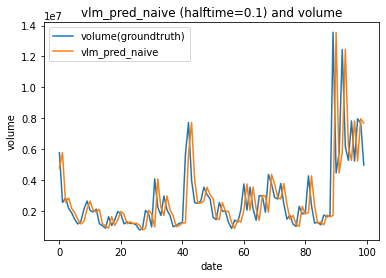

In [5]:
# EWMA with halftime = 0.1
model_ewma_simple_copy = EWMA(halftime=0.1)
data_simple_copy = model_ewma_simple_copy.predict(ori_data)
plt.plot(data_simple_copy['volume'].loc['A'].to_numpy()[:100], label='volume(groundtruth)')
plt.plot(data_simple_copy['vlm_pred_naive'].loc['A'].to_numpy()[:100], label='vlm_pred_naive')
plt.xlabel('date')
plt.ylabel('volume')
plt.title('vlm_pred_naive (halftime=0.1) and volume')
plt.legend()

From the above figure, we easily see that the orange curve (predicted volumes using *EWMA* with halftime 0.1) is a simple right-shift of the blue curve (groundtruth volumes), demonstrating that our *EWMA* model is constructed correctly.

Then, we can build *EWMA* with *halftime* = 60 as our naive volume prediction model.

In [6]:
# EWMA with halftime = 60
model_ewma = EWMA(halftime=60)
data_with_pred = model_ewma.predict(ori_data)
data_with_pred

price_adj  price_close  price_open  price_high   price_low  \
uspn date                                                                      
A    2000-01-05   38.372894    44.617310   47.389126   47.567955   43.141987   
     2000-01-06   36.911816    42.918453   44.080830   44.349072   41.577251   
     2000-01-07   39.987797    46.494991   42.247852   47.165592   42.203148   
     2000-01-10   42.410137    49.311516   49.356224   49.803291   48.327969   
     2000-01-11   41.833397    48.640915   49.311516   49.311516   47.523247   
...                     ...          ...         ...         ...         ...   
ZTS  2019-12-24  132.513702   132.919998  132.210007  133.080002  131.289993   
     2019-12-26  132.623352   133.029999  133.190002  133.190002  132.320007   
     2019-12-27  132.842697   133.250000  133.399994  133.479996  132.380005   
     2019-12-30  131.805878   132.210007  133.570007  133.660004  131.809998   
     2019-12-31  131.945450   132.350006  132.009995  132.580002  131.449997   

                    volume  sp_weight   ret_raw  price_change  vlm_pred_naive  \
uspn date                                                                       
A    2000-01-05  5758600.0   0.096007 -0.062030      0.062030    4.765000e+06   
     2000-01-06  2534400.0   0.096007 -0.038076      0.038076    5.264670e+06   
     2000-01-07  2819600.0   0.096007  0.083333      0.083333    4.344046e+06   
     2000-01-10  2148400.0   0.096007  0.060577      0.060577    3.956305e+06   
     2000-01-11  1855900.0   0.096007 -0.013599      0.013599    3.586322e+06   
...                    ...        ...       ...           ...             ...   
ZTS  2019-12-24   442500.0   0.240081  0.004155      0.004155    2.135535e+06   
     2019-12-26   929400.0   0.240081  0.000827      0.000827    2.116089e+06   
     2019-12-27  1296100.0   0.240081  0.001654      0.001654    2.102459e+06   
     2019-12-30   942000.0   0.240081 -0.007805      0.007805    2.093197e+06   
     2019-12-31  1128600.0   0.240081  0.001059      0.001059    2.079974e+06   

                        y  
uspn date                  
A    2000-01-05  0.208520  
     2000-01-06 -0.518602  
     2000-01-07 -0.350928  
     2000-01-10 -0.456968  
     2000-01-11 -0.482506  
...                   ...  
ZTS  2019-12-24 -0.792792  
     2019-12-26 -0.560794  
     2019-12-27 -0.383531  
     2019-12-30 -0.549971  
     2019-12-31 -0.457397  

[2249977 rows x 11 columns]

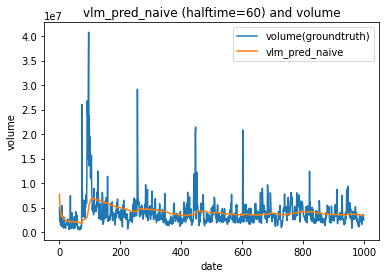

In [7]:
plt.plot(data_with_pred['volume'].loc['ZTS'].to_numpy()[:1000], label='volume(groundtruth)')
plt.plot(data_with_pred['vlm_pred_naive'].loc['ZTS'].to_numpy()[0:1000], label='vlm_pred_naive')
plt.xlabel('date')
plt.ylabel('volume')
plt.title('vlm_pred_naive (halftime=60) and volume')
plt.legend()

We see that the predicted curve generally follows the overall trend of the groundtruth curve, despite not able to display any sharp peaks.

We first compare groundtruth *volume* and prediction *vlm_pred_naive* by scattering them.

Text(0.5, 1.0, 'scatter vlm_pred_naive v.s. volume')

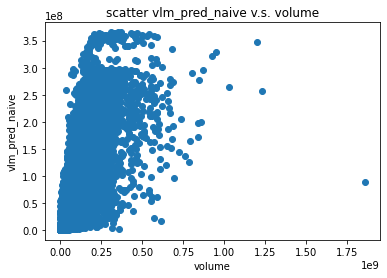

In [8]:
plt.scatter(data_with_pred['volume'].to_numpy(), data_with_pred['vlm_pred_naive'].to_numpy())
plt.xlabel('volume')
plt.ylabel('vlm_pred_naive')
plt.title('scatter vlm_pred_naive v.s. volume')

From the above scattering figure, we see a rough linear relationships between *volume* and *vlm_pred_naive*. This makes sense since we only use historical volume data to predict today's volume data, which is too simple and could not provide enough information. The deviation of the $t$th day's volume, impacted by lots of other factors, could be significantly large.

We can also regress *vlm_pred_naive* on *volume*. Here is the summary of results.

In [10]:
result = sm.ols(formula="vlm_pred_naive ~ volume", data=data_with_pred).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         vlm_pred_naive   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                 6.576e+06
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:20:43   Log-Likelihood:            -3.8240e+07
No. Observations:             2249977   AIC:                         7.648e+07
Df Residuals:                 2249975   BIC:                         7.648e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.263e+06   4150.203    304.291      0.000    1.25e+06    1.27e+06
volume         0.7504      0.000   2564.297      0.000       0.750       0.751
==============================================================================
Omnibus:                  3614380.870   Durbin-Watson:                   0.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     301408653532.958
Skew:                          -8.877   Prob(JB):                         0.00
Kurtosis:                    1795.971   Cond. No.                     1.52e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the $R^2$ metrics is 0.745, and the coefficient is 0.7504 with t-stat 2564.297. The coefficient is smaller than 1 because EWMA cannot predict sharp peaks, and therefore averagely smaller than groundthruth.

Next, we focus on searching for the correlations between *y = volume/vlm_pred_naive - 1* and various price features. We can do the linear regression of *y* on all price features, including *price_adj*, *price_close*, *price_open*, *price_high*, *price_low*, *price_change*. We find that the coefficients before *price_adj*, *price_close*, and *price_open* have too small t stats. Therefore, here we only show the results of regressing *y* on *price_high*, *price_low*, *price_change*.

In [11]:
result = sm.ols(formula="y ~ price_high + price_low + price_change",
         data=data_with_pred).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9367.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:20:46   Log-Likelihood:            -5.1317e+06
No. Observations:             2249977   AIC:                         1.026e+07
Df Residuals:                 2249973   BIC:                         1.026e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1844      0.002    -81.090      0.000      -0.189      -0.180
price_high       0.0331      0.001     33.952      0.000       0.031       0.035
price_low       -0.0337      0.001    -33.876      0.000      -0.036      -0.032
price_change    13.2671      0.093    142.634      0.000      13.085      13.449
==================================================================================
Omnibus:                 16694802.301   Durbin-Watson:                       1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   134905190009480336.000
Skew:                        1000.364   Prob(JB):                             0.00
Kurtosis:                 1199586.011   Cond. No.                         1.06e+04
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that *y = volume/vlm_pred_naive - 1* is positively correlated to *price_high - price_low* and *price_change*. This is consistent with my intuition. A larger *price_high - price_low* means the stock has large fluctuations at that day, which causes more people contributing to buy-and-sell. Note that *price_change[stock, date] = (price_adj[stock, date] - price_adj[stock, date-1]) / price_adj[stock, date-1]*. When the price of the stock has large change compared to the price of the previous day, more people will contribute to buy-and-sell.

## Part 2: Using LSTM to predict volume

In this part, we can try to use Long short-term memory (LSTM) to do the stock volume prediction. First, we construct a *Scaler* class to normalize each column and also record the means and deviations of each column for original data. Then, we use the data from 2000 to 2015 as the training data and the data from 2016 to 2020 as the test data. 

In [12]:
class Scaler():
    def __init__(self):
        self.mu = None
        self.sd = None

    def norm(self, df):
        self.mu = df.mean()
        self.sd = df.std()
        norm_df = (df - self.mu) / self.sd
        return norm_df

scaler = Scaler()

ori_data_norm = scaler.norm(ori_data)
ori_data_resetidx = ori_data_norm.reset_index()
train_data = ori_data_resetidx[ori_data_resetidx['date'] < '2016-01-01']
test_data = ori_data_resetidx[ori_data_resetidx['date'] >= '2016-01-01']
train_data.set_index(['date', 'uspn'], inplace=True)
test_data.set_index(['date', 'uspn'], inplace=True)

We convert the train and test dataframes to numpy arrays. We also record the length of dates with non-nan data for each stock.

In [13]:
def get_data_arr(df):
  # input: df, train or test data in df fromat
  # output: data_arr, (num_stocks, num_dates, num_features) array, with 5 price features and volume
  #      length, (num_stock,) array, length of dates with non-nan data for each stock 
  columns = ['price_adj',	'price_close', 'price_open', 'price_high', 'price_low', 'volume']
  data_arr = []
  for column in columns:
    data_arr.append(pd.DataFrame(df[column]).unstack().sort_index(axis=1).to_numpy().T[:, :, np.newaxis])
  data_arr = np.concatenate(data_arr, axis=2) # (num_stocks, num_dates, num_features)
  index_nan = np.isnan(data_arr[:, :, 0])
  lengths = np.count_nonzero(1 - index_nan, axis=1) # (num_stocks,)
  return data_arr, lengths
  
train_data_arr, train_lengths = get_data_arr(train_data)
test_data_arr, test_lengths = get_data_arr(test_data)

We move all nan to the bottom and replace them by zeros. in order to more easily handle the varying lengths of effective dates for each stock. 

In [14]:
# move all nan to the bottom and replace them by zeros
def move_nan_bottom(data):
  num_stocks, num_dates, num_features = data.shape
  rows, columns, heights = np.ogrid[:num_stocks, :num_dates, :num_features]
  index_nan = np.isnan(data)
  nan_count = np.count_nonzero(index_nan, axis=1)
  is_first_nan = np.isnan(data[:, 0, :]).astype(int)
  nan_count = np.multiply(nan_count, is_first_nan)
  nan_count = nan_count[:, np.newaxis, :]
  columns = columns + nan_count - num_dates
  data = data[rows, columns, heights]
  data[np.isnan(data)] = 0
  return data

train_data_arr = move_nan_bottom(train_data_arr)
test_data_arr = move_nan_bottom(test_data_arr)

Now, we can build train and test dataset, with shape of \\
X: (len(dataset), window_size, num_feature) \\
src_lengths: (len(dataset),) \\
Y: (len(dataset),) \\
After converting to dataloaders, len(dataset) is replaced by batch_size.

In [15]:
# generate training and test dataset
def get_dataset(data_arr, lengths, window_size=60):
  num_stocks, num_dates, num_features = data_arr.shape
  X = []
  Y = []
  src_lengths = []
  for i in range(num_stocks):
    # forcasting days < window_size: do zero padding
    for day in range(1, min(lengths[i], window_size)):
      temp = data_arr[i, :day, :] # (day, num_features)
      temp = np.concatenate([temp, np.zeros((window_size-day, num_features))], axis=0)
      X.append(temp[np.newaxis, :, :]) # (1, window_size, num_features)
      Y.append(np.array(data_arr[i, day+1, -1]).reshape(1,)) # (1,)
      src_lengths.append(np.array(day).reshape(1,)) # (1,)
    # forcasting days == window_size
    X_i = []
    n_row = lengths[i] - window_size
    if n_row > 0:
      for j in range(num_features):
        x = data_arr[i, :, j]
        output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size),
                              strides=(x.strides[0], x.strides[0]))
        X_i.append(output[:, :, np.newaxis]) 
      X_i = np.concatenate(X_i, axis=2) # (n_row, window_size, num_features)
      Y_i = data_arr[i, window_size: lengths[i], -1] # (n_row,)
      X.append(X_i)
      Y.append(Y_i)
      src_lengths.append(np.ones(n_row) * 60) # (n_row,)
  X = np.concatenate(X, axis=0)
  Y = np.concatenate(Y, axis=0)
  src_lengths = np.concatenate(src_lengths, axis=0)
  X_ten, Y_ten = torch.tensor(X).type(torch.FloatTensor), torch.tensor(Y).type(torch.FloatTensor)
  src_lengths_ten = torch.tensor(src_lengths).type(torch.IntTensor)
  dataset = data_utils.TensorDataset(X_ten, src_lengths_ten, Y_ten)

  return dataset

# generate datasets
train_dataset = get_dataset(train_data_arr, train_lengths, window_size=60)
test_dataset = get_dataset(test_data_arr, test_lengths, window_size=60)

Next, we can build the LSTM model. The number of LSTM layers is set to be 2, a medium number that ensures the model complexity and prevents overfitting. We also use a dropout with 0.5 for LSTM layers for regularization. The technique of *pack_padded_sequence* is also utilized to handle early days of a stock (i.e., *t*th day with *t < window_size*).

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.5):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.linear1 = nn.Linear(self.input_size, self.hidden_size)

        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.num_layers,
                   batch_first=True, dropout=dropout, bidirectional=False)
        
        self.linear2 = nn.Linear(self.num_layers * self.hidden_size, 1)

    def forward(self, x, seq_len):
        # x: (batch_size, window_size, num_features)
        # seq_len: (batch_size,)
        # out: (batch_size,)
        batch_size = x.shape[0]
        x = nn.ReLU()(self.linear1(x))
        packed_x = pack_padded_sequence(x, seq_len.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_x) # (num_layers, batch_size, hidden_size]
        out = h_n.permute(1, 0, 2).reshape(batch_size, -1) # (batch_size, num_layers*hidden_size)
        out = self.linear2(out) # (batch_size, 1)
        return out.squeeze()

We can define train and test functions.

In [19]:
# train and test function
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    sum_loss = 0
    num_batch_since_log = 0

    batches = tqdm(enumerate(train_loader), total=len(train_loader))
    batches.set_description("Epoch NA: Loss (NA)")
    for batch_idx, (data, src_lengths, target) in batches:
        # data: (batch_size, window_size, num_features)
        # src_lengths: (batch_size,)
        # target: (batch_size,)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, src_lengths) # (batch_size,)
        loss = criterion(output, target)
        sum_loss += loss.item()
        num_batch_since_log += 1  
        loss.backward()
        optimizer.step()
        ave_loss = sum_loss / num_batch_since_log
        batches.set_description("Epoch {:d}: Train loss ({:.2e})".format(epoch, ave_loss))

def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    num_batch_since_log = 0
    with torch.no_grad():
        for data, src_lengths, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, src_lengths)
            test_loss += criterion(output, target).item()
            num_batch_since_log += 1

    test_loss /= num_batch_since_log
    print('\n Test loss ({:.2e})'.format(test_loss))
    return test_loss

We define hyperparameters and do the training.

In [37]:
# hyperparameters
args = dict()
args["seed"] = 27456
args["batch_size"] = 256
args["epochs"] = 5
args["lr"] = 5e-5
args["input_size"] = 6
args["hidden_size"] = 16

torch.manual_seed(args["seed"])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# build model, optimizer, and criterion
model = LSTM(input_size=args["input_size"], hidden_size=args["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
criterion = nn.MSELoss()

# define train and test loader
train_loader = data_utils.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = data_utils.DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

# train and test the model
for epoch in range(1, args["epochs"] + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss = test(model, device, criterion, test_loader)

model_wts = copy.deepcopy(model.state_dict())
save_dir = "/content/drive/MyDrive/best_weights"
torch.save(model_wts, os.path.join(save_dir, 'LSTM_weights.pt'))

Epoch 1: Train loss (5.71e-01): 100%|██████████| 6852/6852 [01:12<00:00, 94.65it/s]



 Test loss (8.77e-02)


Epoch 2: Train loss (3.34e-01): 100%|██████████| 6852/6852 [01:14<00:00, 92.37it/s]



 Test loss (8.02e-02)


Epoch 3: Train loss (2.81e-01): 100%|██████████| 6852/6852 [01:11<00:00, 95.29it/s]



 Test loss (7.79e-02)


Epoch 4: Train loss (2.56e-01): 100%|██████████| 6852/6852 [01:12<00:00, 94.82it/s]



 Test loss (7.72e-02)


Epoch 5: Train loss (2.42e-01): 100%|██████████| 6852/6852 [01:11<00:00, 95.73it/s]



 Test loss (7.57e-02)


Then we can predict volumes of 2016-2020 for each stock, which will be a (len(test_dataset),) array.

In [38]:
# vlm_pred: (len(test_dataset),) array recording predicted volumes for 2016-2020
test_loader = data_utils.DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=False)
model.eval()
vlm_pred = []
for data, src_lengths, _ in test_loader:
  data = data.to(device)
  vlm_pred.append(model(data, src_lengths).detach().cpu().numpy())
vlm_pred = np.concatenate(vlm_pred, axis=0)
vlm_pred = (vlm_pred * scaler.sd['volume']) + scaler.mu['volume']

For baseline, we add *vlm_pred_naive*, the prediction using EWMA with halftime 60, and *vlm_simple_copy*, the simple copy of the previous day's data, as two columns. We then add *vlm_pred* as a new column in *test_data*, add also calculate *y = volume/vlm_pred_naive - 1*, *x0 = vlm_simple_copy/vlm_pred_naive - 1*, and *x = vlm_pred/vlm_pred_naive - 1* as three new columns.

In [39]:
test_data_with_pred = test_data.reset_index().set_index(['date']).groupby('uspn').\
            apply(lambda group: group.iloc[1:, :]).drop(columns=['uspn'])
test_data_with_pred = (test_data_with_pred * scaler.sd) + scaler.mu

test_data_with_pred['vlm_pred_naive'] = data_with_pred['vlm_pred_naive']
test_data_with_pred['vlm_simple_copy'] = data_simple_copy['vlm_pred_naive']
test_data_with_pred['vlm_pred'] = vlm_pred
test_data_with_pred['y'] = test_data_with_pred['volume'] / test_data_with_pred['vlm_pred_naive'] - 1 
test_data_with_pred['x0'] = test_data_with_pred['vlm_simple_copy'] / test_data_with_pred['vlm_pred_naive'] - 1
test_data_with_pred['x'] = test_data_with_pred['vlm_pred'] / test_data_with_pred['vlm_pred_naive'] - 1

test_data_with_pred

price_adj  price_close  price_open  price_high   price_low  \
uspn date                                                                      
A    2016-01-05   38.954754    40.549999   40.730000   40.950001   40.340000   
     2016-01-06   39.127674    40.730000   40.240002   40.990002   40.049999   
     2016-01-07   37.465733    39.000000   40.139999   40.150002   38.810001   
     2016-01-08   37.071869    38.590000   39.220001   39.709999   38.470001   
     2016-01-11   36.447437    37.939999   38.709999   38.900002   37.410000   
...                     ...          ...         ...         ...         ...   
ZTS  2019-12-24  132.513702   132.919998  132.210007  133.080002  131.289993   
     2019-12-26  132.623352   133.029999  133.190002  133.190002  132.320007   
     2019-12-27  132.842697   133.250000  133.399994  133.479996  132.380005   
     2019-12-30  131.805878   132.210007  133.570007  133.660004  131.809998   
     2019-12-31  131.945450   132.350006  132.009995  132.580002  131.449997   

                    volume  sp_weight   ret_raw  vlm_pred_naive  \
uspn date                                                         
A    2016-01-05  2587200.0   0.096007 -0.003441    2.721387e+06   
     2016-01-06  2103600.0   0.096007  0.004439    2.719846e+06   
     2016-01-07  3504300.0   0.096007 -0.042475    2.712768e+06   
     2016-01-08  3736700.0   0.096007 -0.010513    2.721859e+06   
     2016-01-11  2818400.0   0.096007 -0.016844    2.733516e+06   
...                    ...        ...       ...             ...   
ZTS  2019-12-24   442500.0   0.240081  0.004155    2.135535e+06   
     2019-12-26   929400.0   0.240081  0.000827    2.116089e+06   
     2019-12-27  1296100.0   0.240081  0.001654    2.102459e+06   
     2019-12-30   942000.0   0.240081 -0.007805    2.093197e+06   
     2019-12-31  1128600.0   0.240081  0.001059    2.079974e+06   

                 vlm_simple_copy    vlm_pred         y        x0         x  
uspn date                                                                   
A    2016-01-05     3.285506e+06  6008428.50 -0.049308  0.207291  1.207855  
     2016-01-06     2.587882e+06  4798897.00 -0.226574 -0.048519  0.764400  
     2016-01-07     2.104073e+06  4088340.75  0.291780 -0.224382  0.507074  
     2016-01-08     3.502933e+06  4548287.50  0.372848  0.286963  0.671022  
     2016-01-11     3.736472e+06  4645793.00  0.031053  0.366911  0.699567  
...                          ...         ...       ...       ...       ...  
ZTS  2019-12-24     1.635898e+06  2022331.75 -0.792792 -0.233963 -0.053009  
     2019-12-26     4.436654e+05  1182804.00 -0.560794 -0.790337 -0.441042  
     2019-12-27     9.289256e+05  1037256.75 -0.383531 -0.558172 -0.506646  
     2019-12-30     1.295741e+06  1098483.75 -0.549971 -0.380975 -0.475212  
     2019-12-31     9.423455e+05  1043057.25 -0.457397 -0.546944 -0.498524  

[495482 rows x 14 columns]

We first scatter *vlm_simple_copy* versus *volume* and do the linear regression, as a base line.

Text(0.5, 1.0, 'scatter vlm_simple_copy v.s. volume')

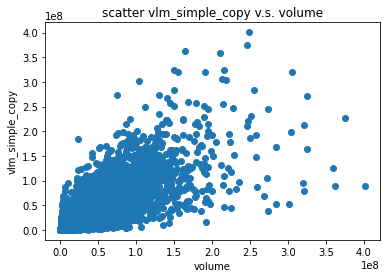

In [41]:
plt.scatter(test_data_with_pred['volume'].to_numpy(), test_data_with_pred['vlm_simple_copy'].to_numpy())
plt.xlabel('volume')
plt.ylabel('vlm_simple_copy')
plt.title('scatter vlm_simple_copy v.s. volume')

In [24]:
result = sm.wls(formula="vlm_simple_copy ~ volume", data=test_data_with_pred,
         weights=test_data_with_pred['sp_weight'].to_numpy()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        vlm_simple_copy   R-squared:                       0.786
Model:                            WLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 1.821e+06
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:31:35   Log-Likelihood:            -8.6463e+06
No. Observations:              495482   AIC:                         1.729e+07
Df Residuals:                  495480   BIC:                         1.729e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.05e+06   1.11e+04     94.552      0.000    1.03e+06    1.07e+06
volume         0.8873      0.001   1349.492      0.000       0.886       0.889
==============================================================================
Omnibus:                   572696.766   Durbin-Watson:                   2.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       8801911873.111
Skew:                           4.526   Prob(JB):                         0.00
Kurtosis:                     655.888   Cond. No.                     2.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the $R^2$ metrics is 0.786, and the coefficient is 0.8873 with t-stat 1349.492.

Then, we scatter *vlm_pred* versus *volume* and do the linear regression.

Text(0.5, 1.0, 'scatter vlm_pred v.s. volume')

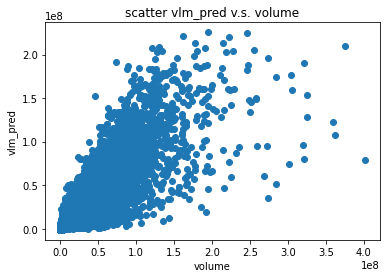

In [42]:
plt.scatter(test_data_with_pred['volume'].to_numpy(), test_data_with_pred['vlm_pred'].to_numpy())
plt.xlabel('volume')
plt.ylabel('vlm_pred')
plt.title('scatter vlm_pred v.s. volume')

In [43]:
result = sm.wls(formula="vlm_pred ~ volume", data=test_data_with_pred,
         weights=test_data_with_pred['sp_weight'].to_numpy()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               vlm_pred   R-squared:                       0.818
Model:                            WLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 2.222e+06
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:48:11   Log-Likelihood:            -8.5821e+06
No. Observations:              495482   AIC:                         1.716e+07
Df Residuals:                  495480   BIC:                         1.716e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.132e+06   9750.386    116.049      0.000    1.11e+06    1.15e+06
volume         0.8610      0.001   1490.781      0.000       0.860       0.862
==============================================================================
Omnibus:                   543945.308   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6132274342.410
Skew:                          -4.118   Prob(JB):                         0.00
Kurtosis:                     547.945   Cond. No.                     2.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the  $R^2$  metrics is 0.818, and the coefficient is 0.8610 with t-stat 1490.781. From the standpoint of high $R^2$ and high t-stat, it seems that the predicted volumes using learned LSTM produces better results.

However, a better method to evaluate the model is to do univariate cross-sectional regression. Here, we regress *y* on *x0* and regress *y* on *x* individually.

In [44]:
# y ~ x0
result = sm.wls(formula="y ~ x0", data=test_data_with_pred,
         weights=test_data_with_pred['sp_weight'].to_numpy()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            WLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4527.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:48:19   Log-Likelihood:            -1.3273e+06
No. Observations:              495482   AIC:                         2.655e+06
Df Residuals:                  495480   BIC:                         2.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0054      0.004     -1.510      0.131      -0.012       0.002
x0             0.4528      0.007     67.285      0.000       0.440       0.466
================================================================================
Omnibus:                  3281827.527   Durbin-Watson:                     2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   3621921881276880.000
Skew:                         624.997   Prob(JB):                           0.00
Kurtosis:                  418853.738   Cond. No.                           1.89
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# y ~ x
result = sm.wls(formula="y ~ x", data=test_data_with_pred,
         weights=test_data_with_pred['sp_weight'].to_numpy()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1092.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          3.66e-239
Time:                        19:48:22   Log-Likelihood:            -1.3290e+06
No. Observations:              495482   AIC:                         2.658e+06
Df Residuals:                  495480   BIC:                         2.658e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0134      0.004     -3.748      0.000      -0.020      -0.006
x              0.0085      0.000     33.042      0.000       0.008       0.009
================================================================================
Omnibus:                  3272974.757   Durbin-Watson:                     1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   3518903333997240.000
Skew:                         618.214   Prob(JB):                           0.00
Kurtosis:                  412854.057   Cond. No.                           14.0
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the $R^2$ metrics for $y \sim x_0$ is 0.009, while that for $y \sim x$ is only 0.002. The t-stat of the coefficient for $y \sim x_0$ is 67.285, while that for $y \sim x$ is only 33.042. Therefore, the learnt LSTM model actually does not perform better in a statistically significant degree. We now plot *vlm_pred* and *volume* together to see what happened.

Text(0.5, 1.0, 'vlm_pred and volume comparison')

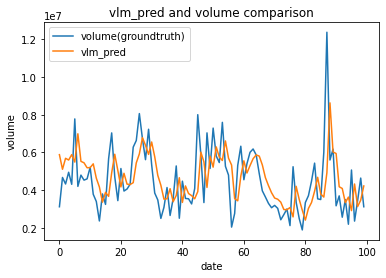

In [46]:
plt.plot(test_data_with_pred['volume'].loc['ZTS'].to_numpy()[:100], label='volume(groundtruth)')
plt.plot(test_data_with_pred['vlm_pred'].loc['ZTS'].to_numpy()[0:100], label='vlm_pred')
plt.xlabel('date')
plt.ylabel('volume')
plt.legend()
plt.title('vlm_pred and volume comparison')

We see that the predicted curve by LSTM still looks like a right shift of the groundtruth curve, even with some rescaling and fluctuations. After searching on the Internet, I know that this is the key disadvantage of using LSTM or other RNN-based deep learning models for stock prediction. Due to the overfitting, the model is always learning a right-shift effect. In order to better predict stock volumes, we still need to search a more appropriate model. Maybe we can try to use Conv-LSTM model, which means doing one-dimensional convolution before feeding the features into LSTM layers. Also, we can try some dimensionality reduction methods including principal component analysis (PCA). These can be further investigated in the following work.